# Main project/home work

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from datetime import datetime

from tqdm import tqdm, trange

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.gridspec as gridspec

from IPython.display import display

In [2]:
from hw_utils import *

In [3]:
import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [4]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [5]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

target_colors = np.array([cm.magma(0.5), cm.magma(0.75), cm.magma(0.93)])
feature_colors = np.array([rocket_cmap(0.17), cm.magma(0.45), cm.magma(0.60), cm.magma(0.75)])

## 1. Load and preprocess data

### 1./a. Load and explore data

In [6]:
os.listdir(data)

['cars.csv']

In [7]:
%%time
# ENCODING: utf-8 can't handle some continuation bytes, so I choose `ISO-8859-1` for this task
# NA_VALUES: NaN values are stored as 'nan' and 'NaN' values in the dataset
# TRUE/FALSE VALUES: There are binary entries marked with the 'ja'/'nein' German words
df = pd.read_csv(data + 'cars.csv', encoding='ISO-8859-1',
                 na_values=['nan', 'NaN'], true_values=['ja'], false_values=['nein'])
# The columns called 'name', and 'postalCode' can be easily dropped,
# since they're only ID-like columns and doesn't necessary contan any useful information
df = df.drop(labels=['name', 'postalCode'], axis=1)
# The columns `dateCrawled`, `dateCreated` and `lastSeen` are
# automatically generated values for this specific dataset,
# which can be dropped in normal circumstances.
# However let's keep the `dateCrawled` and `lastSeen` features
# to combine them into one continuous feature.
df = df.drop(labels=['dateCreated'], axis=1)
d_1 = np.array([datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['dateCrawled'].values])
d_2 = np.array([datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['lastSeen'].values])
d_d = d_2 - d_1
df['soldMin'] = np.array([d.seconds/60 for d in d_d])
df = df.drop(labels=['dateCrawled', 'lastSeen'], axis=1)

# The column `nrOfPictures` contains exclusively the value `0`. It can be dropped.
df = df.drop(labels=['nrOfPictures'], axis=1)
# The columns 'seller' and 'offerType' are incomprehensibly biased and contains
# almost entirely a single value. They can be dropped with an ease
df = df.drop(labels=['seller', 'offerType'], axis=1)

CPU times: user 6.97 s, sys: 117 ms, total: 7.08 s
Wall time: 7.09 s


In [8]:
display(df.head())
display(df.tail())

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,soldMin
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,924.666667
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,True,888.083333
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,1435.416667
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,False,46.216667
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,False,1012.016667


,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,soldMin
371523,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,418.416667
371524,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,False,1340.850000
371525,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,False,738.233333
371526,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN,1024.216667
371527,28990,control,limousine,2013,manuell,320,m_reihe,50000,8,benzin,bmw,False,457.850000


In [9]:
def return_unique(df, label):
    return np.unique(df[label][~df.isna()[label]],
                     return_counts=True)

### Explore the unique values by features

In [10]:
#print('price :\n', return_unique(df, label='price'), '\n')          # Continuous, but not boring, contains mock values
#print('seller :\n', return_unique(df, label='seller'), '\n')        # Incomprehensibly biased, should be dropped
#print('offerType :\n', return_unique(df, label='offerType'), '\n')  # Incomprehensibly biased, should be dropped
print('abtest :\n', return_unique(df, label='abtest'), '\n')         # This is not an informative value, but still interesting
print('vehicleType :\n', return_unique(df, label='vehicleType'), '\n')
print('yearOfRegistration :\n', return_unique(df, label='yearOfRegistration'), '\n')
print('gearbox :\n', return_unique(df, label='gearbox'), '\n')
#print('powerPS :\n', return_unique(df, label='powerPS'), '\n')      # Continuous, also boring
print('model :\n', return_unique(df, label='model'), '\n')
print('kilometer :\n', return_unique(df, label='kilometer'), '\n')
print('monthOfRegistration :\n', return_unique(df, label='monthOfRegistration'), '\n')
print('fuelType :\n', return_unique(df, label='fuelType'), '\n')
print('brand :\n', return_unique(df, label='brand'), '\n')
print('notRepairedDamage :\n', return_unique(df, label='notRepairedDamage'), '\n')
#print('nrOfPictures :\n', return_unique(df, label='nrOfPictures'), '\n') # Contains only 0 values, can be dropped
#print('soldMin :\n', return_unique(df, label='soldMin'), '\n')      # Continuous, also boring

abtest :
 (array(['control', 'test'], dtype=object), array([178943, 192585])) 

vehicleType :
 (array(['andere', 'bus', 'cabrio', 'coupe', 'kleinwagen', 'kombi',
       'limousine', 'suv'], dtype=object), array([ 3357, 30201, 22898, 19015, 80023, 67564, 95894, 14707])) 

yearOfRegistration :
 (array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1911, 1915, 1919, 1920, 1923, 1925,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010,

In [11]:
# Select categorical and continuous column names
columns = np.array(df.columns)
columns_cat = np.array(['abtest', 'yearOfRegistration', 'gearbox', 'model', 'kilometer', 'monthOfRegistration','fuelType', 'brand', 'notRepairedDamage'])
columns_con = np.array(['price', 'powerPS', 'soldMin'])

### 1./b. Explore and handle NaN values

In [12]:
# Create a mask to analyze missing entries easier
nan_mask = df.isna()
nan_count = nan_mask.sum()
print('Count of missing values:\n' +
      '========================')
print(tabulate([[c, nan_count[c]] for c in nan_count.index], headers=['Feature', 'Count of NaNs']))

Count of missing values:
Feature                Count of NaNs
-------------------  ---------------
price                              0
abtest                             0
vehicleType                    37869
yearOfRegistration                 0
gearbox                        20209
powerPS                            0
model                          20484
kilometer                          0
monthOfRegistration                0
fuelType                       33386
brand                              0
notRepairedDamage              72060
soldMin                            0


Showing all values on a figure is sadly can't be conveniently done, because the `cars.csv` file contains too much rows compared to its number of columns. This table should replace that classic figure here.

Since all those columns that miss values are categorical features, we have to either drop them totally, or fill them with appropriately sampled values to keep the NaN-less distribution of features unchanged. Let's examine first, how many rows should we drop if we drop all with at least one NaN value.

In [13]:
# Create a copy of the old dataframe for reusability
df_n = df.copy()
df_n = df_n.dropna(axis=0, how='any')

# Fraction of dropped rows
print('Dropped {:.2f}% of all original rows.'.format((1 - len(df_n) / len(df)) * 100))

Dropped 29.76% of all original rows.


Okay, I'll drop them...

### 1./c. Inspect distribution of continous values

In [14]:
hist = {}
bins = {}
width = {}
center = {}

for c in columns_con:
    hist[c], bins[c] = np.histogram(df_n[c], bins=10, density=True)
    width[c] = 0.8 * (bins[c][1] - bins[c][0])
    center[c] = (bins[c][:-1] + bins[c][1:]) / 2

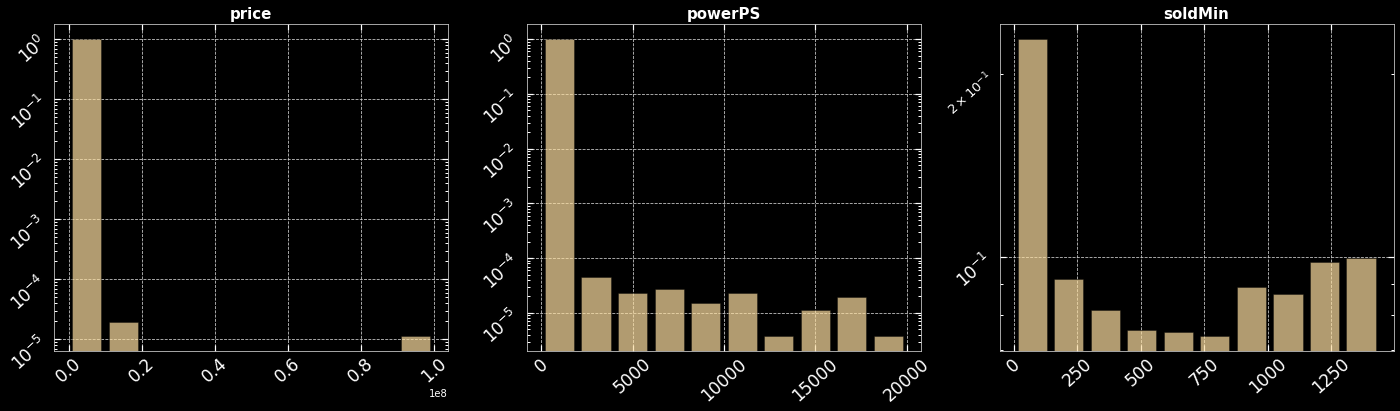

In [15]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*6),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# Loop through axes/features
for col_i, ax in enumerate(axes.reshape(-1)):
    ax.set_yscale('log')
    col = columns_con[col_i]

    ax.bar(center[col], hist[col] / hist[col].sum(), width=width[col],
           color=cm.magma(0.93), alpha=0.7,
           ec='black', lw=0.5, align='center')
    ax.set_title(col, fontsize=axistitlesize-5, fontweight='bold', color='white')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   labelrotation=42, colors='white')
    ax.tick_params(axis='both', which='minor', labelsize=axisticksize-4,
                   labelrotation=42, colors='white')

#plt.suptitle('Fig. 2. Distribution of non-binary labels in the original dataset.',
#             color='white', fontsize=axistitlesize+5, y=-0.04)

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_1_dist_pre.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

In [16]:
display(df_n.head())
display(df_n.tail())

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,soldMin
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,False,46.216667
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,False,1012.016667
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,True,100.733333
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,False,1289.800000
7,0,test,limousine,1980,manuell,50,andere,40000,7,benzin,volkswagen,False,1313.333333


,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,soldMin
371520,3200,control,limousine,2004,manuell,225,leon,150000,5,benzin,seat,True,50.900000
371521,1150,control,bus,2000,manuell,0,zafira,150000,3,benzin,opel,False,821.050000
371524,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,False,1340.850000
371525,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,False,738.233333
371527,28990,control,limousine,2013,manuell,320,m_reihe,50000,8,benzin,bmw,False,457.850000


### 1./d. Handle placeholder/faulty/mock values

Some columns contains obviously fake values, inputted for whatever reason into the dataset. These values should be filtered out using some meaningful/sane measure. Here I'll list all rules I formulated and used to filter fake values in the dataset.

#### 1. `price`
On Fig 2. we can see, that mock values here are really huge, probably values like `999999999` or similar placeholder values widely used in digital enviroments. They're are separates from real values and  on the far right side We can easly filter these values by deleting them over some threshold. Let us choose this threshold to be over $3$ million.

#### 2. `yearOfRegistration`
Fake values here are all over the spectrum. Feature values are ranging from `1000` to `9999`. Values before `1900` and after `2020` can be obviously dropped.

#### 3. `powerPS`
Representing the engine's power output in horsepower. A Bugatti Veyron's engine is approximately capped at $1200$ HP, while a main battle tank's engine can be output up to $2000$ HP. All values above eg. $1500$ can be dropped.

In [17]:
# Create a copy of the old dataframe for reusability
df_f = df_n.copy()

# Drop rows with mock `price` values
df_f = df_f[df_f['price'] < 3_000_000]

# Drop rows with mock `yearOfRegistration` values
df_f = df_f[df_f['yearOfRegistration'] >= 1900][df_f['yearOfRegistration'] <= 2020]

# Drop rows with mock `powerPS` values
df_f = df_f[df_f['powerPS'] <= 1500]

# Convert binary labels to 0,1 digits
# Collect the datalabels
df_f['abtest'] = df_f['abtest'].map({'control' : 0, 'test' : 1})
df_f['gearbox'] = df_f['gearbox'].map({'automatik' : 0, 'manuell' : 1})
df_f['notRepairedDamage'] = df_f['notRepairedDamage'].map({False : 0, True : 1})

In [18]:
display(df_f)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,soldMin
3,1500,1,kleinwagen,2001,1,75,golf,150000,6,benzin,volkswagen,0,46.216667
4,3600,1,kleinwagen,2008,1,69,fabia,90000,7,diesel,skoda,0,1012.016667
5,650,1,limousine,1995,1,102,3er,150000,10,benzin,bmw,1,100.733333
6,2200,1,cabrio,2004,1,109,2_reihe,150000,8,benzin,peugeot,0,1289.800000
7,0,1,limousine,1980,1,50,andere,40000,7,benzin,volkswagen,0,1313.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,0,limousine,2004,1,225,leon,150000,5,benzin,seat,1,50.900000
371521,1150,0,bus,2000,1,0,zafira,150000,3,benzin,opel,0,821.050000
371524,1199,1,cabrio,2000,0,101,fortwo,125000,3,benzin,smart,0,1340.850000
371525,9200,1,bus,1996,1,102,transporter,150000,3,diesel,volkswagen,0,738.233333


In [19]:
hist = {}
bins = {}
width = {}
center = {}

for c in columns_con:
    hist[c], bins[c] = np.histogram(df_f[c], bins=10, density=True)
    width[c] = 0.8 * (bins[c][1] - bins[c][0])
    center[c] = (bins[c][:-1] + bins[c][1:]) / 2

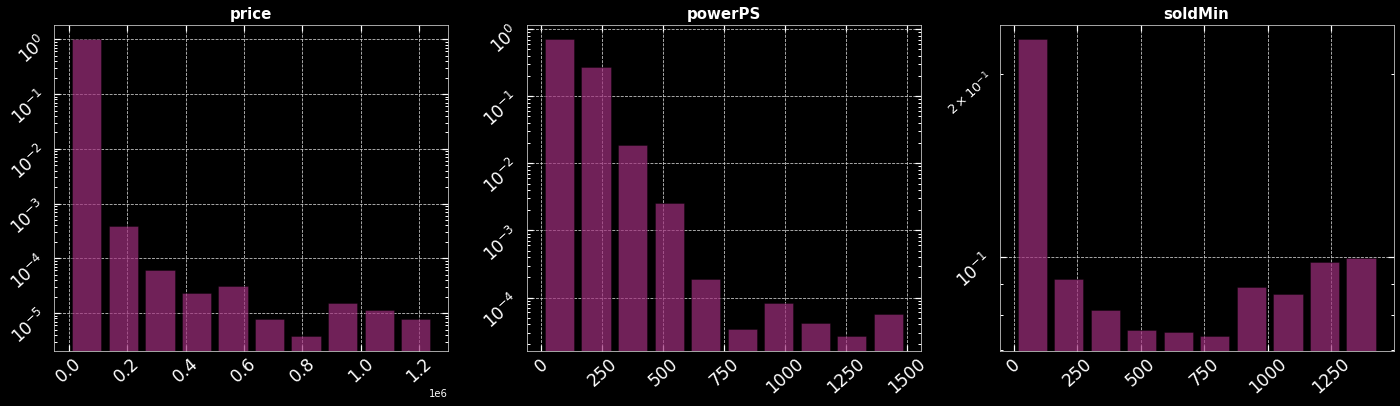

In [20]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*6),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# Loop through axes/features
for col_i, ax in enumerate(axes.reshape(-1)):
    ax.set_yscale('log')
    col = columns_con[col_i]

    ax.bar(center[col], hist[col] / hist[col].sum(), width=width[col],
           color=cm.magma(0.45), alpha=0.7,
           ec='black', lw=0.5, align='center')
    ax.set_title(col, fontsize=axistitlesize-5, fontweight='bold', color='white')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   labelrotation=42, colors='white')
    ax.tick_params(axis='both', which='minor', labelsize=axisticksize-4,
                   labelrotation=42, colors='white')

#plt.suptitle('Fig. 3. Distribution of continous labels in the modified dataset after filtering\n' +
#             'out all placeholder/faulty/mock feature values. Note, that only `price` and `powerPS`\n' +
#             'were altered during the filtering.',
#             color='white', fontsize=axistitlesize+5, y=-0.04)

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_2_dist_after.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

#### Check unique values in the final dataset

In [21]:
print('abtest :\n', return_unique(df_f, label='abtest'), '\n')
print('vehicleType :\n', return_unique(df_f, label='vehicleType'), '\n')
print('yearOfRegistration :\n', return_unique(df_f, label='yearOfRegistration'), '\n')
print('gearbox :\n', return_unique(df_f, label='gearbox'), '\n')
print('model :\n', return_unique(df_f, label='model'), '\n')
print('kilometer :\n', return_unique(df_f, label='kilometer'), '\n')
print('monthOfRegistration :\n', return_unique(df_f, label='monthOfRegistration'), '\n')
print('fuelType :\n', return_unique(df_f, label='fuelType'), '\n')
print('brand :\n', return_unique(df_f, label='brand'), '\n')
print('notRepairedDamage :\n', return_unique(df_f, label='notRepairedDamage'), '\n')

abtest :
 (array([0, 1]), array([125397, 135464])) 

vehicleType :
 (array(['andere', 'bus', 'cabrio', 'coupe', 'kleinwagen', 'kombi',
       'limousine', 'suv'], dtype=object), array([ 1770, 24955, 18546, 14642, 59086, 53414, 76369, 12079])) 

yearOfRegistration :
 (array([1910, 1919, 1923, 1929, 1930, 1931, 1932, 1933, 1934, 1936, 1937,
       1938, 1939, 1941, 1942, 1943, 1945, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018]), array([    3,     1,     2,     1,     4,     4,     2,     1,     2,
           2,     5,     1,     2,     1,     2,     2,     3, 

### 1./e. Explore the feature space of continuous(?) values

In [22]:
import itertools

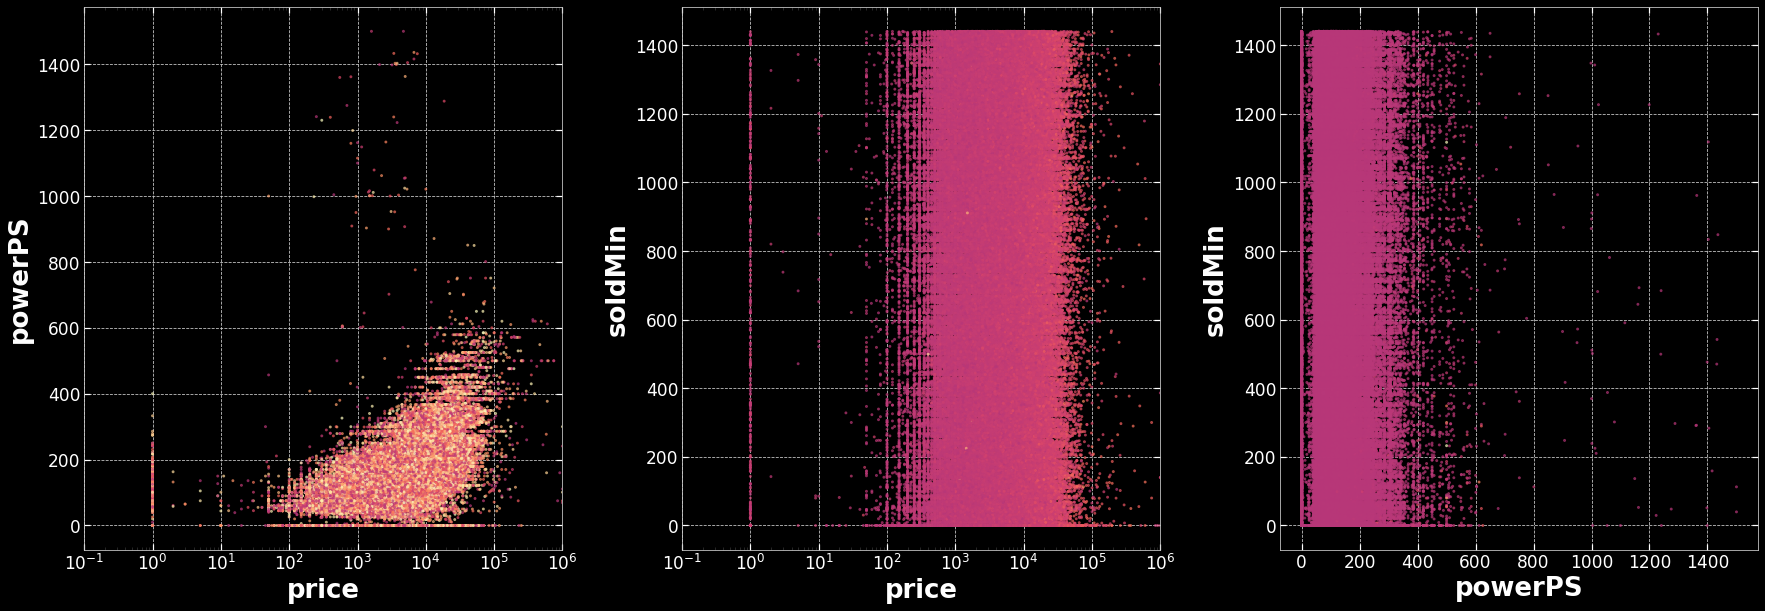

In [23]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(10*ncols, 10*nrows),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(wspace=0.25)
sr = 2

space = list(itertools.combinations(columns_con, 2))
for idx, ax in enumerate(axes.reshape(-1)):
    if idx < 2 :
        ax.set_xscale('log')
        ax.set_xlim(1e-01, 1e06)
    
    i, j = space[idx]                         # Select features for axis
    k = set(columns_con) - set(space[idx])    # Select color for scatterpoints
    y = df_f[k].values.reshape(-1)
    c = cm.magma((y/y.max())/2 + 0.5)
    
    ax.scatter(df_f[i], df_f[j],
               c=c, alpha=0.6, s=sr**2)
    ax.set_xlabel(i, fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.set_ylabel(j, fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white')

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_3_feat_space_pre.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')
    
plt.show()

The graph above indicates us that a lot of entries still contain mock values, like zeros for `powerPS` and ones for `price`. These entries can be also obviously dropped from the dataset. Also the `soldMin` feature seems to be completely random, or at least independent of `price` and `powerPS`.

In [24]:
# Drop mock values from `price` and `powerPS`
df_f = df_f[(df_f['price'] != 1)]
df_f = df_f[(df_f['powerPS'] != 0)]

In [25]:
display(df_f)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,soldMin
3,1500,1,kleinwagen,2001,1,75,golf,150000,6,benzin,volkswagen,0,46.216667
4,3600,1,kleinwagen,2008,1,69,fabia,90000,7,diesel,skoda,0,1012.016667
5,650,1,limousine,1995,1,102,3er,150000,10,benzin,bmw,1,100.733333
6,2200,1,cabrio,2004,1,109,2_reihe,150000,8,benzin,peugeot,0,1289.800000
7,0,1,limousine,1980,1,50,andere,40000,7,benzin,volkswagen,0,1313.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371518,3999,1,kombi,2005,1,3,3er,150000,5,diesel,bmw,0,10.150000
371520,3200,0,limousine,2004,1,225,leon,150000,5,benzin,seat,1,50.900000
371524,1199,1,cabrio,2000,0,101,fortwo,125000,3,benzin,smart,0,1340.850000
371525,9200,1,bus,1996,1,102,transporter,150000,3,diesel,volkswagen,0,738.233333


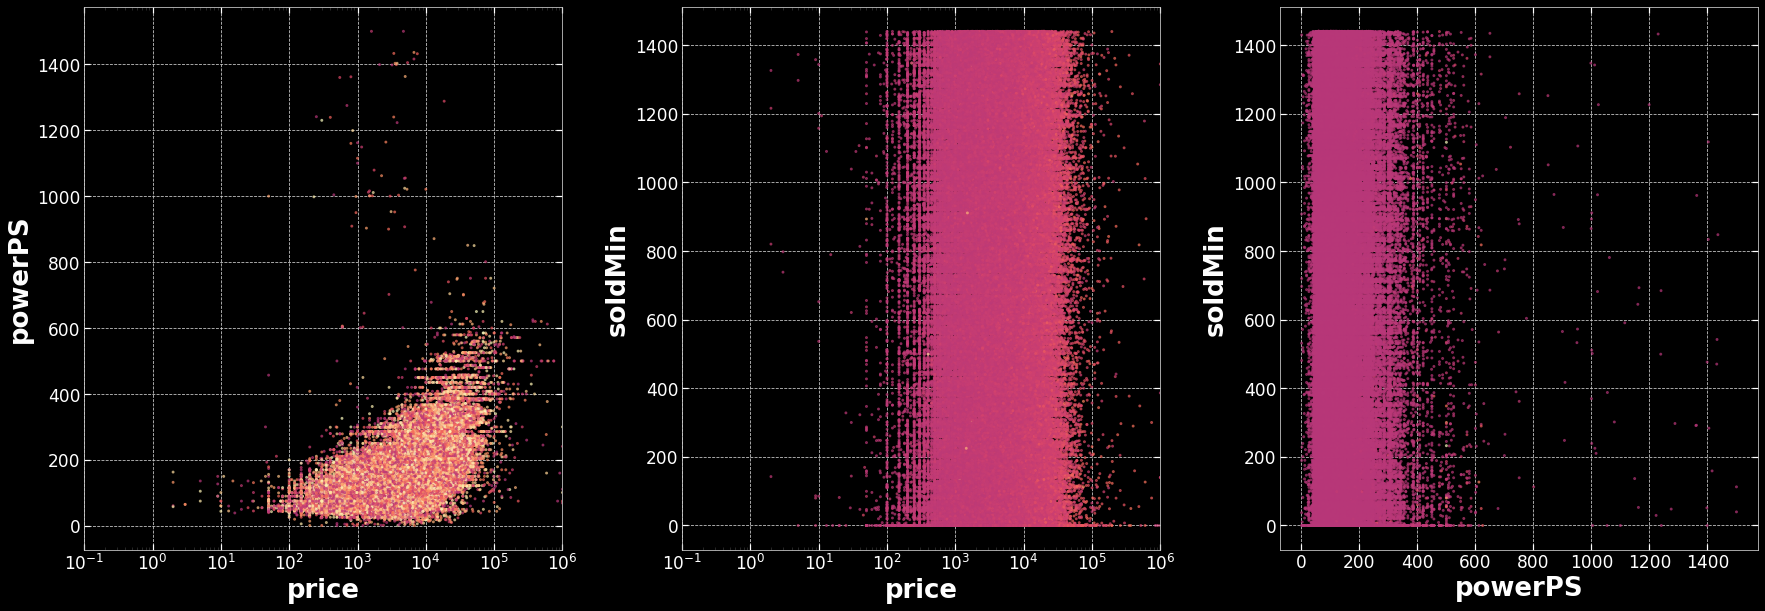

In [63]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(10*ncols, 10*nrows),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(wspace=0.25)
sr = 2

space = list(itertools.combinations(columns_con, 2))
for idx, ax in enumerate(axes.reshape(-1)):
    if idx < 2 :
        ax.set_xscale('log')
        ax.set_xlim(1e-01, 1e06)
    
    i, j = space[idx]                         # Select features for axis
    k = set(columns_con) - set(space[idx])    # Select color for scatterpoints
    y = df_f[k].values.reshape(-1)
    c = cm.magma((y/y.max())/2 + 0.5)
    
    ax.scatter(df_f[i], df_f[j],
               c=c, alpha=0.6, s=sr**2)
    ax.set_xlabel(i, fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.set_ylabel(j, fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white')

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_4_feat_space_after.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')
    
plt.show()

## 2. Show something interesting...

There are a number of things can be looked into using this dataset. Here I'll brainstorm my ideas and try to explore as many things as possible.

#### 2./idea_1. Binary labels from continuous features
Can I predict the binary labels (`abtest`, `gearbox`, `notRepairedDamage`) from the continous features (`price`, `powerPS` and `soldMin`)? Basicly I have no idea what type of connection is there between them, so I'll try various linear models in this case.

#### 2./idea_2. Doing something with `brand`
Is the prediction of `brand` possible somehow?? There are so few features... Is it possible to predict `brand` using again the continous features? Maybe again some linear model?

#### 2./idea_3. Should I implement some Bayesian model with `pyro.ai` or `TF Probability`?
Maybe next time. But probably would be VERY useful here working with a bunch of categorical/categorizable features. Creating a simple Bayesian graph would be probably the best here to explore the CPT between these features and predict eg. the binned `price` feature given all other conditions. The hard part itself lies in the creation of the graph and I have zero idea which nodes should I connect, not even speaking about the direction of edges.

#### 2./idea_4. Predicting `price`
Speaking about `price` prediction I should definitely try to build a model for this.

### Some data exploration visualizations

In [64]:
# Select top brands
brand_unique, brand_count = np.unique(df_f['brand'], return_counts=True)
brand_count, brand_unique = zip(*sorted(zip(brand_count, brand_unique)))

top_n = 9
top_brands = brand_unique[::-1][:top_n]

In [65]:
top_brands

('volkswagen',
 'bmw',
 'mercedes_benz',
 'opel',
 'audi',
 'ford',
 'renault',
 'peugeot',
 'fiat')

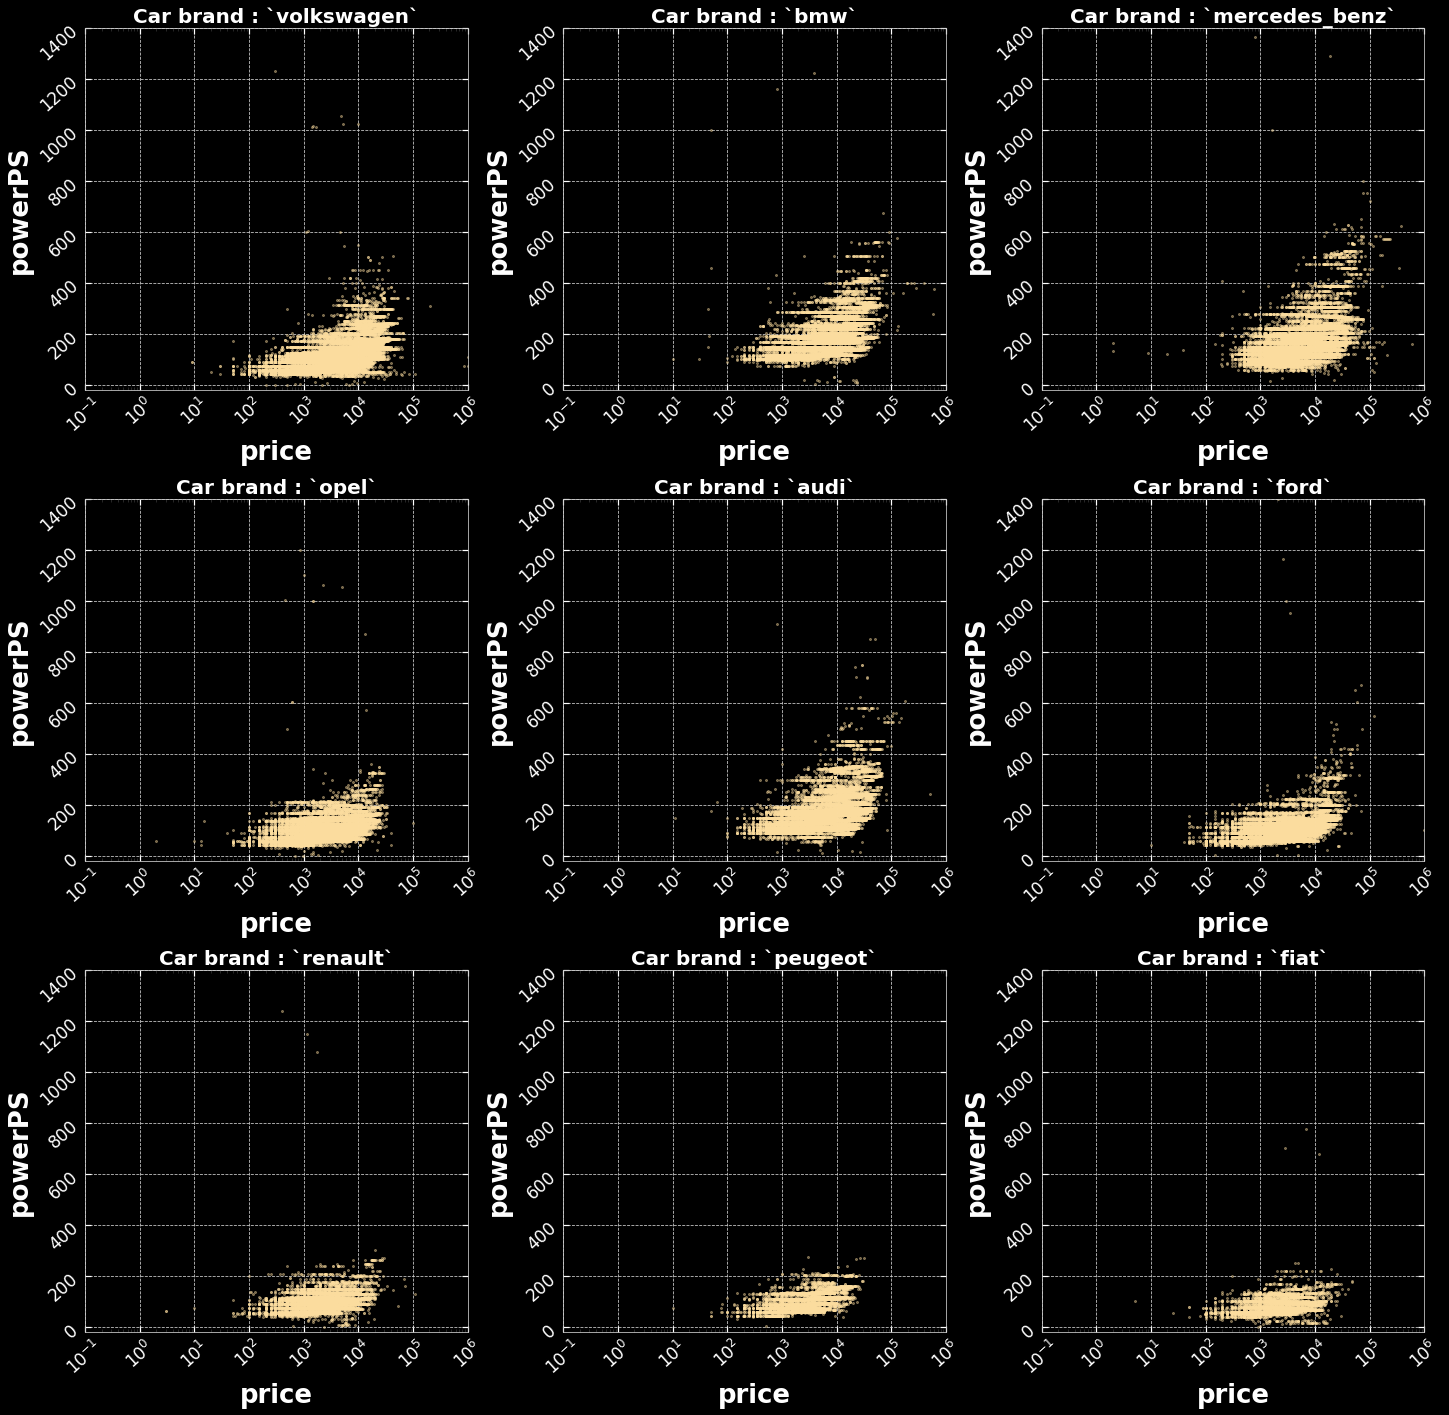

In [66]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(wspace=0.25, hspace=0.3)
sr = 2

for i, ax in enumerate(axes.reshape(-1)):
    ax.set_xscale('log')
    ax.set_xlim(1e-01, 1e06)
    ax.set_ylim(-20, 1400)
    
    t = top_brands[i]
    x = df_f[df_f['brand'] == t]['price']
    y = df_f[df_f['brand'] == t]['powerPS']

    #y = df_f[k].values.reshape(-1)
    #c = cm.magma((y/y.max())/2 + 0.5)
    
    ax.set_title('Car brand : `{}`'.format(t), fontsize=axistitlesize, fontweight='bold', color='white')
    ax.scatter(x, y,
               color=cm.magma(0.93), alpha=0.4, s=sr**2)
    ax.set_xlabel('price', fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.set_ylabel('powerPS', fontsize=axislabelsize, fontweight='bold',
                  color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white', labelrotation=42)

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_5_car_brands.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')
    
plt.show()

## 3. Test idea_1: Binary labels from continous features

Scaling the data is necessary here beacuse of the high-magnitude feature values.

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
def scale_data(X):
    """
    Normalize the data to have zero mean and unit variance.
    
    Parameters:
    -----------
    X : ndarray or array-like in shape of (N, M)
        The unscaled dataset.
    
    Returns:
    --------
    X : ndarray in shape of (N, M)
        The already scaled dataset with zero mean and unit variance.
    """
    # Initialize
    scaler = StandardScaler()
    # Compute the mean and standard dev. and scale the dataset `X`
    X = scaler.fit_transform(X)

    return X

### Create data + label sets

In [32]:
X = df_f[['price', 'powerPS', 'soldMin']]
X = scale_data(np.array(X))

# Collect the datalabels
y_1 = df_f['abtest']
y_2 = df_f['gearbox']
y_3 = df_f['notRepairedDamage']

### Define models

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, RidgeClassifier

In [35]:
def return_linear(X, y, binarize=True, model=LinearRegression(), print_stat=True):
    
    # Split the data into train and test data
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define and fit model
    model_train = model.fit(X_train, y_train)
    model_full = model.fit(X, y)
    # Compute predictions
    pred_train = model_train.predict(X_train)
    pred_test = model_train.predict(X_test)
    pred_full = model_full.predict(X)
    
    if binarize:
        # Binarize predictions
        pred_train[pred_train < model_train.intercept_] = 0
        pred_train[pred_train > model_train.intercept_] = 1
        pred_test[pred_test < model_train.intercept_] = 0
        pred_test[pred_test > model_train.intercept_] = 1
        pred_full[pred_full < model_full.intercept_] = 0
        pred_full[pred_full > model_full.intercept_] = 1
    
    if print_stat:
        print(b1 + 'TRAIN DATASET FIT' + b0 + '\n' +
                   '-----------------')
        #print(b1 + 'Coefficient of determination (TRAIN):' + b0, r_sq_train)
        print(b1 + 'Intercept (TRAIN):' + b0, model_train.intercept_)
        print(b1 + 'Slope coefficients (TRAIN):' + b0)
        for col, mc in zip(columns_con, model_train.coef_):
            print('    {0} : {1}'.format(col, mc))

        print()
        print(b1 + 'FULL DATASET FIT' + b0 + '\n' +
                   '----------------')
        #print(b1 + 'Coefficient of determination (FULL):' + b0, r_sq_full)
        print(b1 + 'Intercept (FULL):' + b0, model_full.intercept_)
        print(b1 + 'Slope coefficients (FULL):' + b0)
        for col, mc in zip(columns_con, model_full.coef_):
            print('    {0} : {1}'.format(col, mc))
    
    return X_train, X_test, y_train, y_test,\
           pred_train, pred_test, pred_full

#### 1./a. Linear regression on `abtest`

In [36]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_1, model=LinearRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 0.5193026251251152
Slope coefficients (TRAIN):
    price : 0.002934401081741557
    powerPS : -0.0033313630244339466
    soldMin : -0.014057632028345512

FULL DATASET FIT
----------------
Intercept (FULL): 0.5193026251251152
Slope coefficients (FULL):
    price : 0.002934401081741557
    powerPS : -0.0033313630244339466
    soldMin : -0.014057632028345512


In [37]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

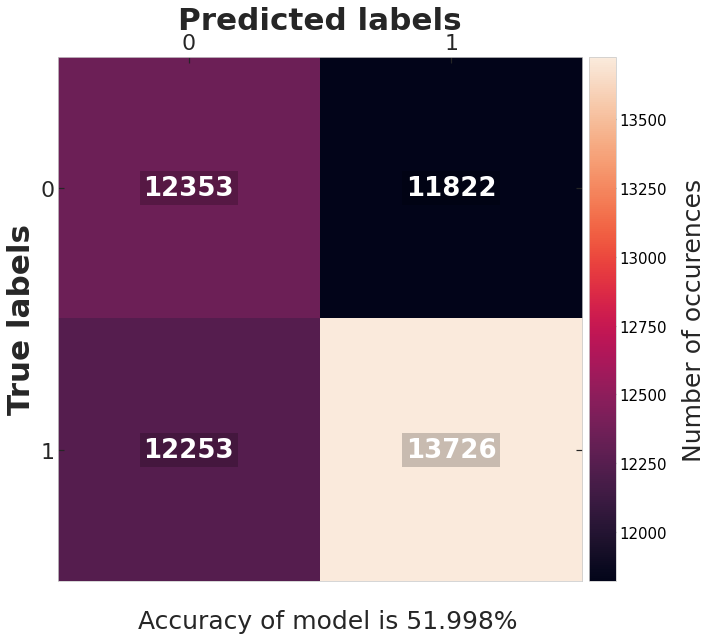

In [38]:
#title=('Fig. 7. Confusion matrix of the predictions on the\n' +
#       'train set of the LinearRegression to predict `abtest` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_6_linear_abtest',
                      figsize=10)

#### 1./b. Linear regression on `gearbox`

In [39]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_2, model=LinearRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 0.7652540784546734
Slope coefficients (TRAIN):
    price : -0.013436414281927682
    powerPS : -0.18317962643766628
    soldMin : -0.0004325524176393286

FULL DATASET FIT
----------------
Intercept (FULL): 0.7652540784546734
Slope coefficients (FULL):
    price : -0.013436414281927682
    powerPS : -0.18317962643766628
    soldMin : -0.0004325524176393286


In [40]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

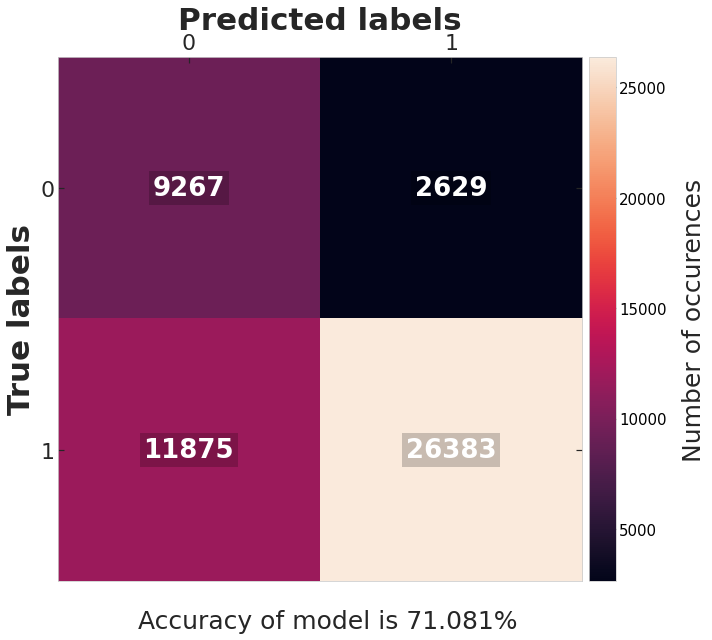

In [41]:
#title=('Fig. 8. Confusion matrix of the predictions on the\n' +
#       'train set of the LinearRegression to predict `gearbox` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_7_linear_gearbox',
                      figsize=10)

#### 1./c. Linear regression on `notRepairedDamage`

In [42]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_3, model=LinearRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 0.10168721014160442
Slope coefficients (TRAIN):
    price : -0.034319046797490434
    powerPS : -0.006461782349138527
    soldMin : -0.007348122667002729

FULL DATASET FIT
----------------
Intercept (FULL): 0.10168721014160442
Slope coefficients (FULL):
    price : -0.034319046797490434
    powerPS : -0.006461782349138527
    soldMin : -0.007348122667002729


In [43]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

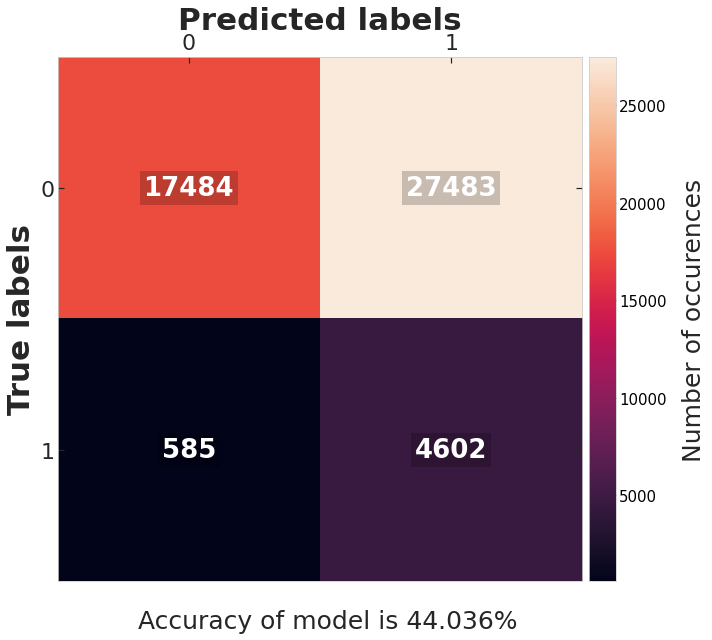

In [44]:
#title=('Fig. 9. Confusion matrix of the predictions on the\n' +
#       'train set of the LinearRegression to predict\n' +
#       '`notRepairedDamage` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_8_linear_notrepaired',
                      figsize=10)

#### 2./a. Logistic regression on `abtest`

In [45]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_1, binarize=False, model=LogisticRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): [0.07731608]
Slope coefficients (TRAIN):
    price : [ 0.01227089 -0.01355963 -0.05634395]

FULL DATASET FIT
----------------
Intercept (FULL): [0.07731608]
Slope coefficients (FULL):
    price : [ 0.01227089 -0.01355963 -0.05634395]


In [46]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

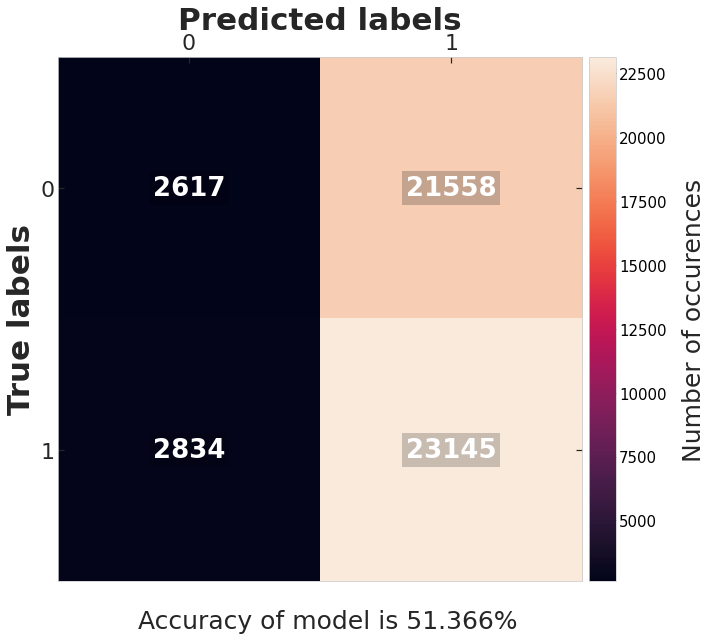

In [47]:
#title=('Fig. 10. Confusion matrix of the predictions on the\n' +
#       'train set of the LogisticRegression to predict `abtest` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_9_logistic_abtest',
                      figsize=10)

#### 2./b. Logistic regression on `gearbox`

In [48]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_2, binarize=False, model=LogisticRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): [1.39320526]
Slope coefficients (TRAIN):
    price : [-1.15102622e-01 -1.19217357e+00  1.40387345e-04]

FULL DATASET FIT
----------------
Intercept (FULL): [1.39320526]
Slope coefficients (FULL):
    price : [-1.15102622e-01 -1.19217357e+00  1.40387345e-04]


In [49]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

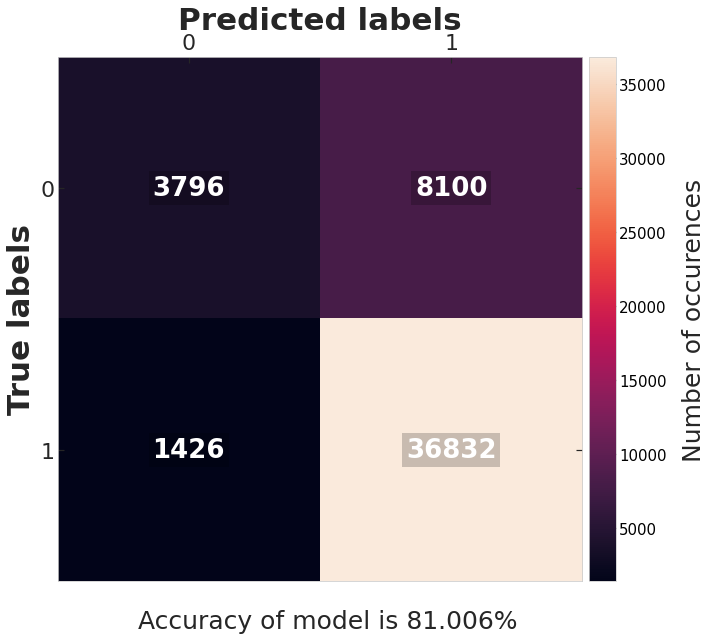

In [50]:
#title=('Fig. 11. Confusion matrix of the predictions on the\n' +
#       'train set of the LogisticRegression to predict `gearbox` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_10_logistic_gearbox',
                      figsize=10)

#### 2./c. Logistic regression on `notRepairedDamage`

In [51]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_3, binarize=False, model=LogisticRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): [-2.96697675]
Slope coefficients (TRAIN):
    price : [-3.37551443  0.30578323 -0.05102654]

FULL DATASET FIT
----------------
Intercept (FULL): [-2.96697675]
Slope coefficients (FULL):
    price : [-3.37551443  0.30578323 -0.05102654]


In [52]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

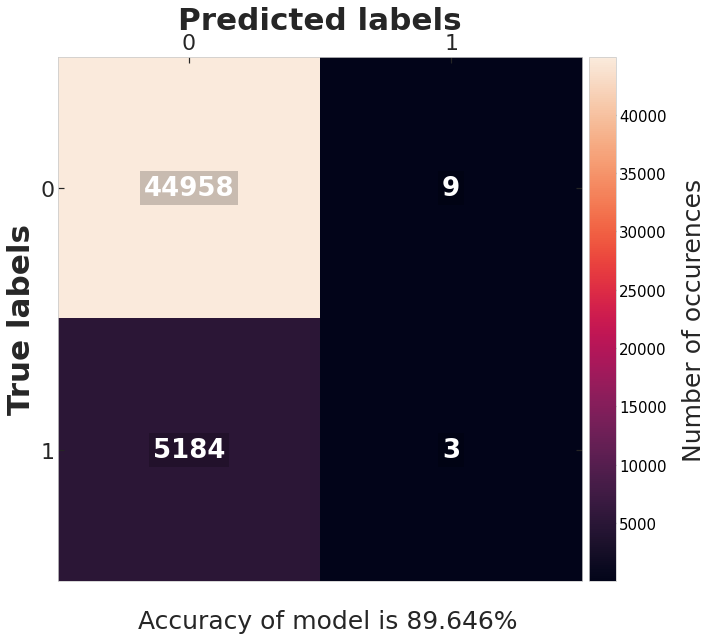

In [53]:
#title=('Fig. 12. Confusion matrix of the predictions on the\n' +
#       'train set of the LogisticRegression to predict\n' +
#       '`notRepairedDamage` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_11_logistic_notrepaired',
                      figsize=10)

#### 3./a. Ridge classifier on `abtest`

In [54]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_1, binarize=False, model=RidgeClassifier(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): [0.03860525]
Slope coefficients (TRAIN):
    price : [ 0.00586876 -0.00666268 -0.02811515]

FULL DATASET FIT
----------------
Intercept (FULL): [0.03860525]
Slope coefficients (FULL):
    price : [ 0.00586876 -0.00666268 -0.02811515]


In [55]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

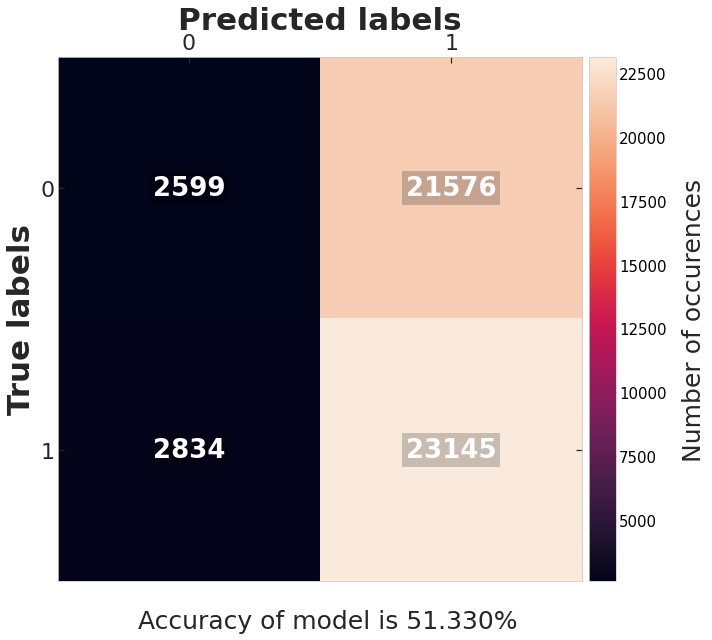

In [56]:
#title=('Fig. 13. Confusion matrix of the predictions on the\n' +
#       'train set of the RidgeClass. to predict `abtest` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_12_ridge_abtest',
                      figsize=10)

#### 3./b. Ridge classifier on `gearbox`

In [57]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_2, binarize=False, model=RidgeClassifier(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): [0.53050816]
Slope coefficients (TRAIN):
    price : [-0.02687348 -0.36635751 -0.0008651 ]

FULL DATASET FIT
----------------
Intercept (FULL): [0.53050816]
Slope coefficients (FULL):
    price : [-0.02687348 -0.36635751 -0.0008651 ]


In [58]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

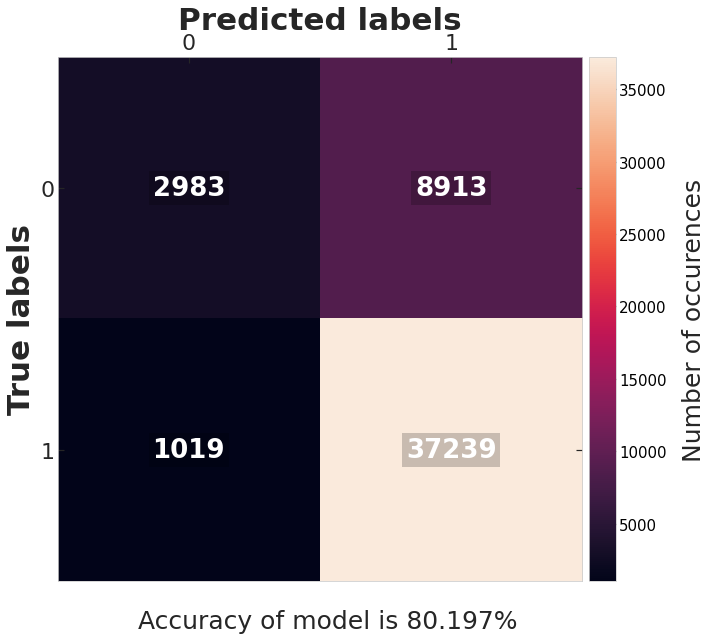

In [59]:
#title=('Fig. 14. Confusion matrix of the predictions on the\n' +
#       'train set of the RidgeClass. to predict `gearbox` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_13_ridge_gearbox',
                      figsize=10)

#### 3./c. Ridge classifier on  `notRepairedDamage`

In [60]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_3, binarize=False, model=RidgeClassifier(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): [-0.79662558]
Slope coefficients (TRAIN):
    price : [-0.06863779 -0.01292365 -0.01469619]

FULL DATASET FIT
----------------
Intercept (FULL): [-0.79662558]
Slope coefficients (FULL):
    price : [-0.06863779 -0.01292365 -0.01469619]


In [61]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

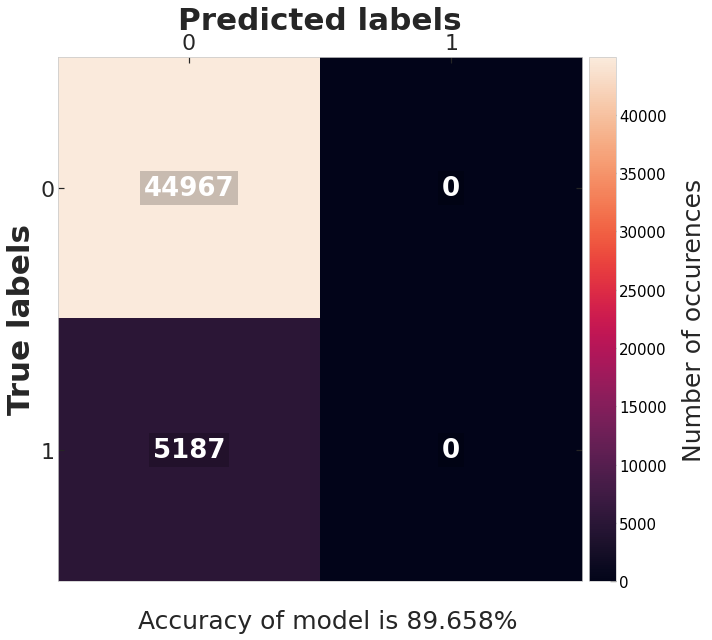

In [62]:
#title=('Fig. 15. Confusion matrix of the predictions on the\n' +
#       'train set of the RidgeClass. to predict\n' +
#       '`notRepairedDamage` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_14_ridge_notrepaired',
                      figsize=10)

#### 3./a. ElasticNet on `abtest`

In [79]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_1, binarize=True, model=ElasticNet(alpha=0.0001, max_iter=1e07), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 0.5193026251251152
Slope coefficients (TRAIN):
    price : 0.0028447253250306957
    powerPS : -0.003242860266108304
    soldMin : -0.014005862699270294

FULL DATASET FIT
----------------
Intercept (FULL): 0.5193026251251152
Slope coefficients (FULL):
    price : 0.0028447253250306957
    powerPS : -0.003242860266108304
    soldMin : -0.014005862699270294


In [80]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

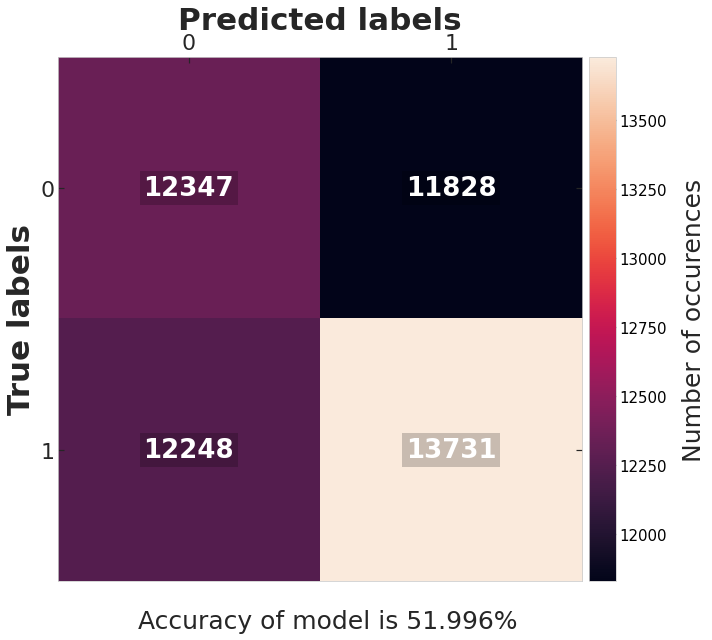

In [81]:
#title=('Fig. 15. Confusion matrix of the predictions on the\n' +
#       'train set of the ElasticNet to predict `abtest` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_15_elastic_abtest',
                      figsize=10)

#### 3./b. ElasticNet on `gearbox`

In [91]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_2, binarize=True, model=ElasticNet(alpha=0.00001, max_iter=1e07), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 0.7652540784546734
Slope coefficients (TRAIN):
    price : -0.013436923865482764
    powerPS : -0.18317354220341425
    soldMin : -0.0004276003430926756

FULL DATASET FIT
----------------
Intercept (FULL): 0.7652540784546734
Slope coefficients (FULL):
    price : -0.013436923865482764
    powerPS : -0.18317354220341425
    soldMin : -0.0004276003430926756


In [92]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

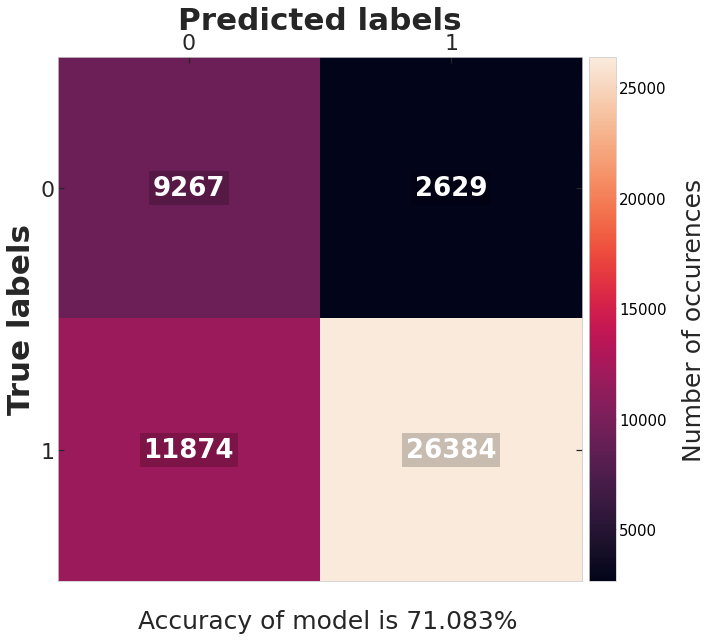

In [93]:
#title=('Fig. 16. Confusion matrix of the predictions on the\n' +
#       'train set of the ElasticNet to predict `gearbox` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_16_elastic_gearbox',
                      figsize=10)

#### 3./c. ElasticNet on  `notRepairedDamage`

In [88]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y_3, binarize=True, model=ElasticNet(alpha=0.00001, max_iter=1e07), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 0.10168721014160442
Slope coefficients (TRAIN):
    price : -0.03431612282817689
    powerPS : -0.006458067312133319
    soldMin : -0.007343187200149212

FULL DATASET FIT
----------------
Intercept (FULL): 0.10168721014160442
Slope coefficients (FULL):
    price : -0.03431612282817689
    powerPS : -0.006458067312133319
    soldMin : -0.007343187200149212


In [89]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=pred_test)
conf_mat = confusion_matrix(y_test, pred_test, labels=[i for i in range(0,2)])

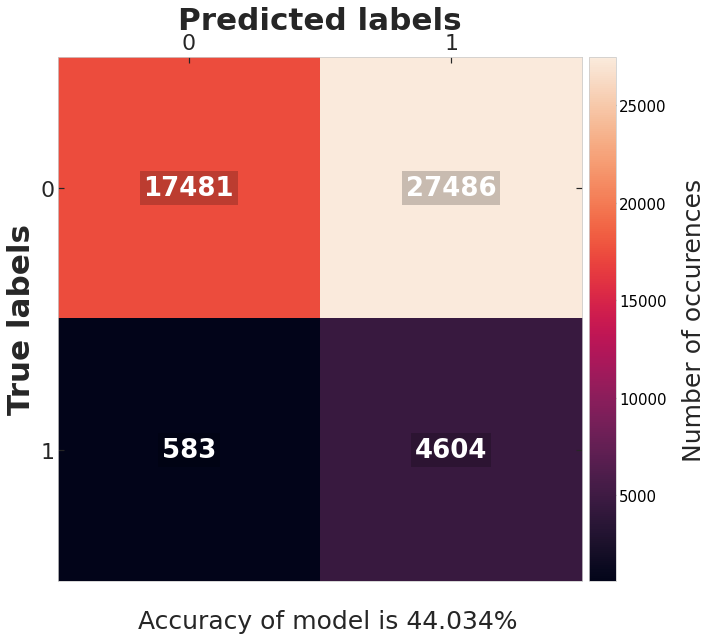

In [90]:
#title=('Fig. 17. Confusion matrix of the predictions on the\n' +
#       'train set of the ElasticNet to predict\n' +
#       '`notRepairedDamage` values.\n' +
#       'Accuracy of model is {0:.3f}%'.format(accuracy))
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,2)],
                      title='Accuracy of model is {0:.3f}%'.format(accuracy),
                      save=True, save_filename='fig_17_elastic_notrepaired',
                      figsize=10)

## 4. Test idea_4: Predict price of cars

In [112]:
from sklearn.metrics import r2_score

In [113]:
def line(X, m, b):
    
    Y = m * X + b
    
    return Y

In [114]:
# Using other continous variables to predict price
X = df_f[['powerPS', 'soldMin']]
X = scale_data(np.array(X))
# Add gearbox values
g = df_f['gearbox'].values
X = np.c_[X,g]

# Collect the datalabels
y = df_f['price'] / 1e02

In [115]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y, binarize=False, model=ElasticNet(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 73.86697797757195
Slope coefficients (TRAIN):
    price : 33.583117890756796
    powerPS : 1.181191950157996
    soldMin : -6.336159917341869

FULL DATASET FIT
----------------
Intercept (FULL): 73.86697797757195
Slope coefficients (FULL):
    price : 33.583117890756796
    powerPS : 1.181191950157996
    soldMin : -6.336159917341869


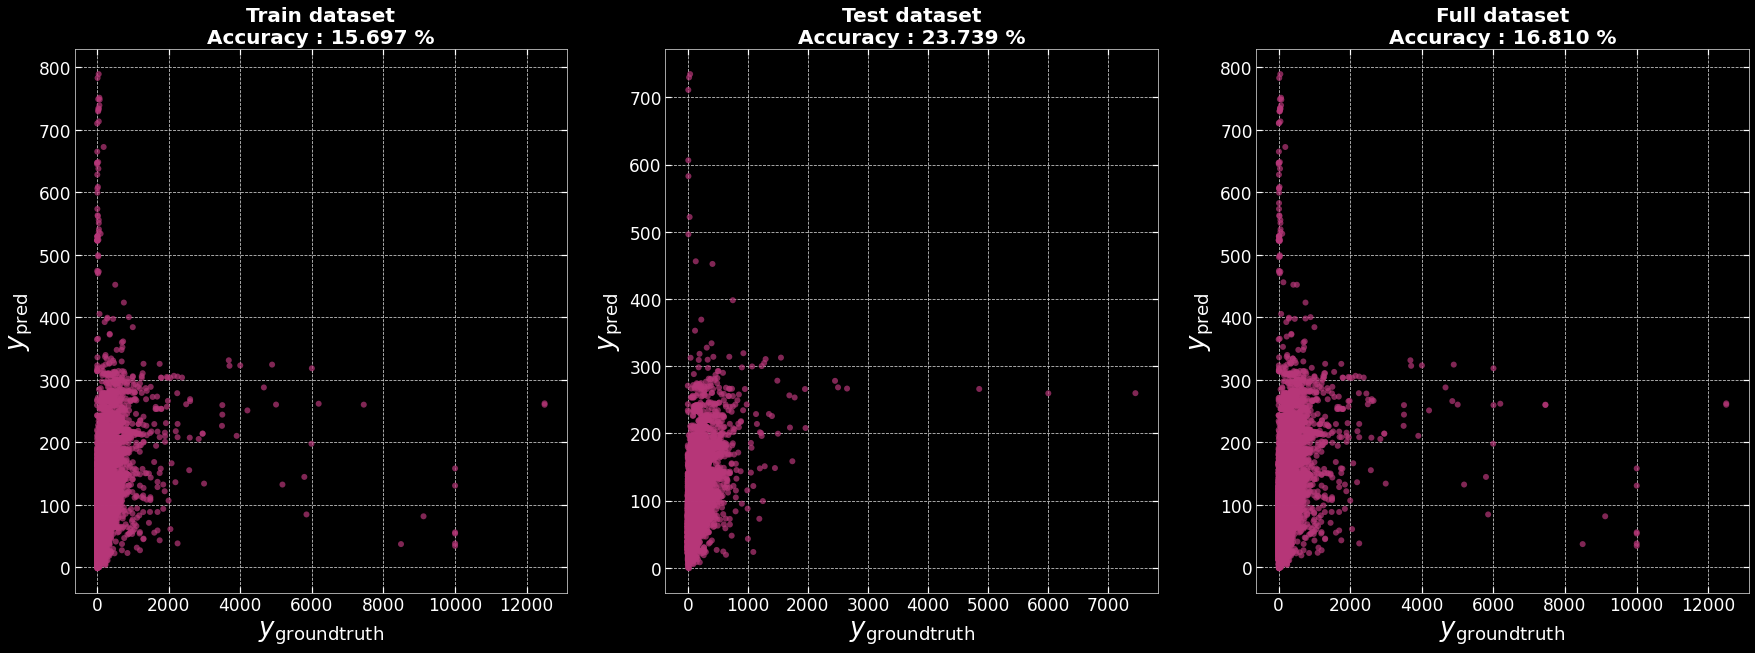

In [116]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

sc = 6

# Pred and groundtruth y values
y_pred = [pred_train, pred_test, pred_full]
y_grnd = [y_train, y_test, y]
# Titles for subplots
titles = ['Train dataset', 'Test dataset', 'Full dataset']
# X values for the m=1, b=0 line
#x_line = np.linspace(0,1,80)
for i in range(ncols):
    ax = axes[i]
    
    #ax.set_xlim(0,1)
    #ax.set_ylim(0,1)
    
    ax.scatter(y_grnd[i], y_pred[i],
               color=cm.magma(0.5), marker='o', ec='none', s=sc**2, alpha=0.7)
    #ax.plot(x_line, line(x_line, m=1, b=0),
    #        color=cm.magma(0.93), lw=3, ls='--', alpha=0.7)
    ax.set_title(titles[i] + '\nAccuracy : {0:.3f} %'.format(r2_score(y_grnd[i], y_pred[i]) * 100),
                 fontsize=axistitlesize, fontweight='bold', color='white')
    ax.set_xlabel('$y_{\mathrm{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('$y_{\mathrm{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    
#fig.suptitle('Fig. 16. Accuracy of predictions for different test samples. In the leftmost and middle figures the model was trained\n' +
#             'only on half of the dataset then the train and test datasets were used respectively for prediction. In the\n' +
#             'rightmost figure the full dataset was used for both training and prediction.',
#             color='white', fontsize=axistitlesize+5, y=0.00)

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_15_ealstic_price.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

In [118]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_linear(X, y, binarize=False, model=LinearRegression(), print_stat=True)

TRAIN DATASET FIT
-----------------
Intercept (TRAIN): 75.98996882958691
Slope coefficients (TRAIN):
    price : 50.341076293251945
    powerPS : 2.096105721719262
    soldMin : -9.110389956470907

FULL DATASET FIT
----------------
Intercept (FULL): 75.98996882958691
Slope coefficients (FULL):
    price : 50.341076293251945
    powerPS : 2.096105721719262
    soldMin : -9.110389956470907


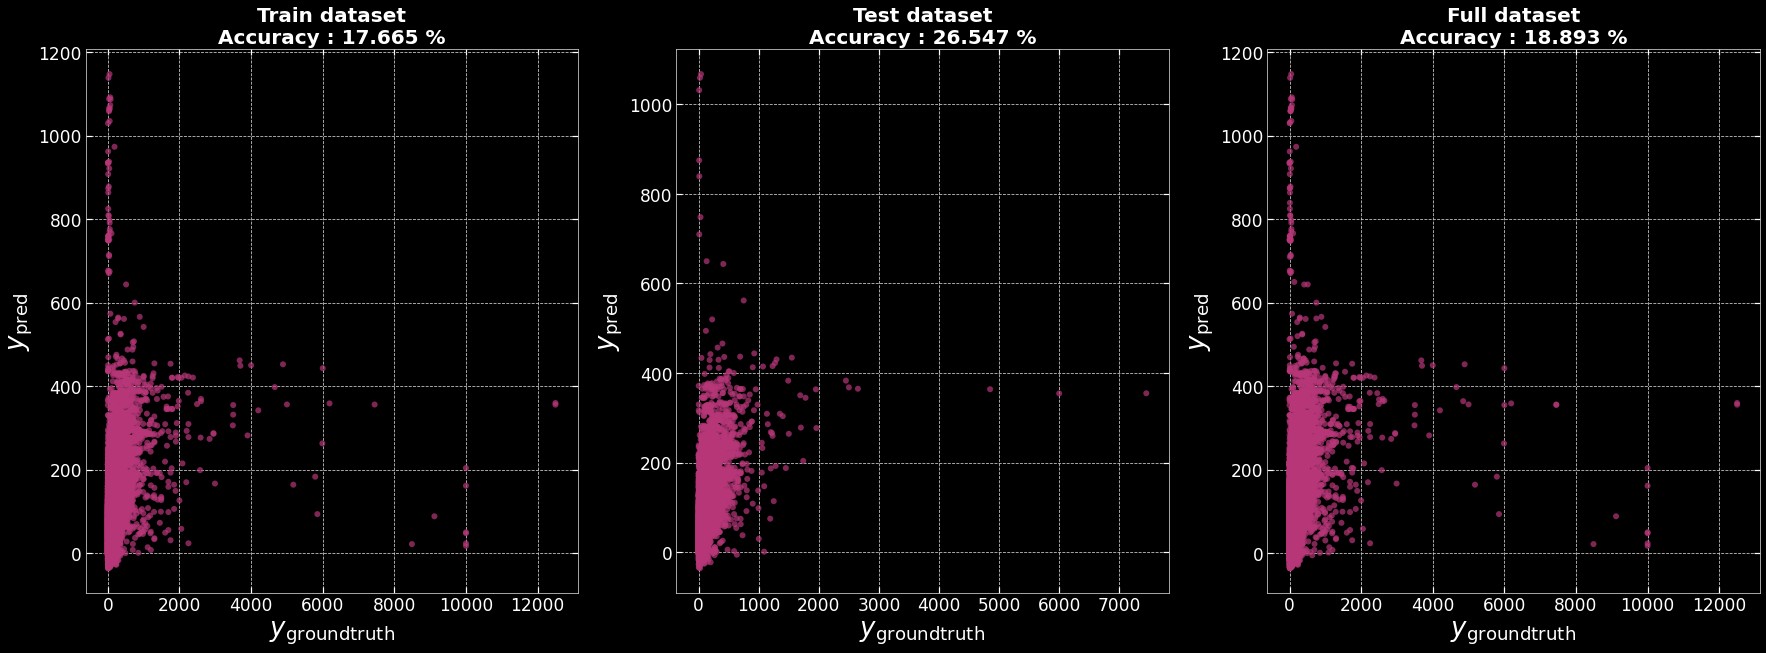

In [119]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

sc = 6

# Pred and groundtruth y values
y_pred = [pred_train, pred_test, pred_full]
y_grnd = [y_train, y_test, y]
# Titles for subplots
titles = ['Train dataset', 'Test dataset', 'Full dataset']
# X values for the m=1, b=0 line
#x_line = np.linspace(0,1,80)
for i in range(ncols):
    ax = axes[i]
    
    #ax.set_xlim(0,1)
    #ax.set_ylim(0,1)
    
    ax.scatter(y_grnd[i], y_pred[i],
               color=cm.magma(0.5), marker='o', ec='none', s=sc**2, alpha=0.7)
    #ax.plot(x_line, line(x_line, m=1, b=0),
    #        color=cm.magma(0.93), lw=3, ls='--', alpha=0.7)
    ax.set_title(titles[i] + '\nAccuracy : {0:.3f} %'.format(r2_score(y_grnd[i], y_pred[i]) * 100),
                 fontsize=axistitlesize, fontweight='bold', color='white')
    ax.set_xlabel('$y_{\mathrm{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('$y_{\mathrm{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

if not os.path.exists(out):
    os.makedirs(out)
plt.savefig(out + 'fig_16_linear_price.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')
    
plt.show()

np.c_### Support Vector Machine -- regression

In [103]:
from sklearn.svm import SVR

In [105]:
def return_svm(X, y, model=SVR()):
    
    # Split the data into train and test data
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define and fit model
    model_train = model.fit(X_train, y_train)
    model_full = model.fit(X, y)
    # Compute predictions
    pred_train = model_train.predict(X_train)
    pred_test = model_train.predict(X_test)
    pred_full = model_full.predict(X)
    
    return X_train, X_test, y_train, y_test,\
           pred_train, pred_test, pred_full

In [106]:
X_train, X_test, y_train, y_test,\
    pred_train, pred_test, pred_full = return_svm(X, y, model=SVR())

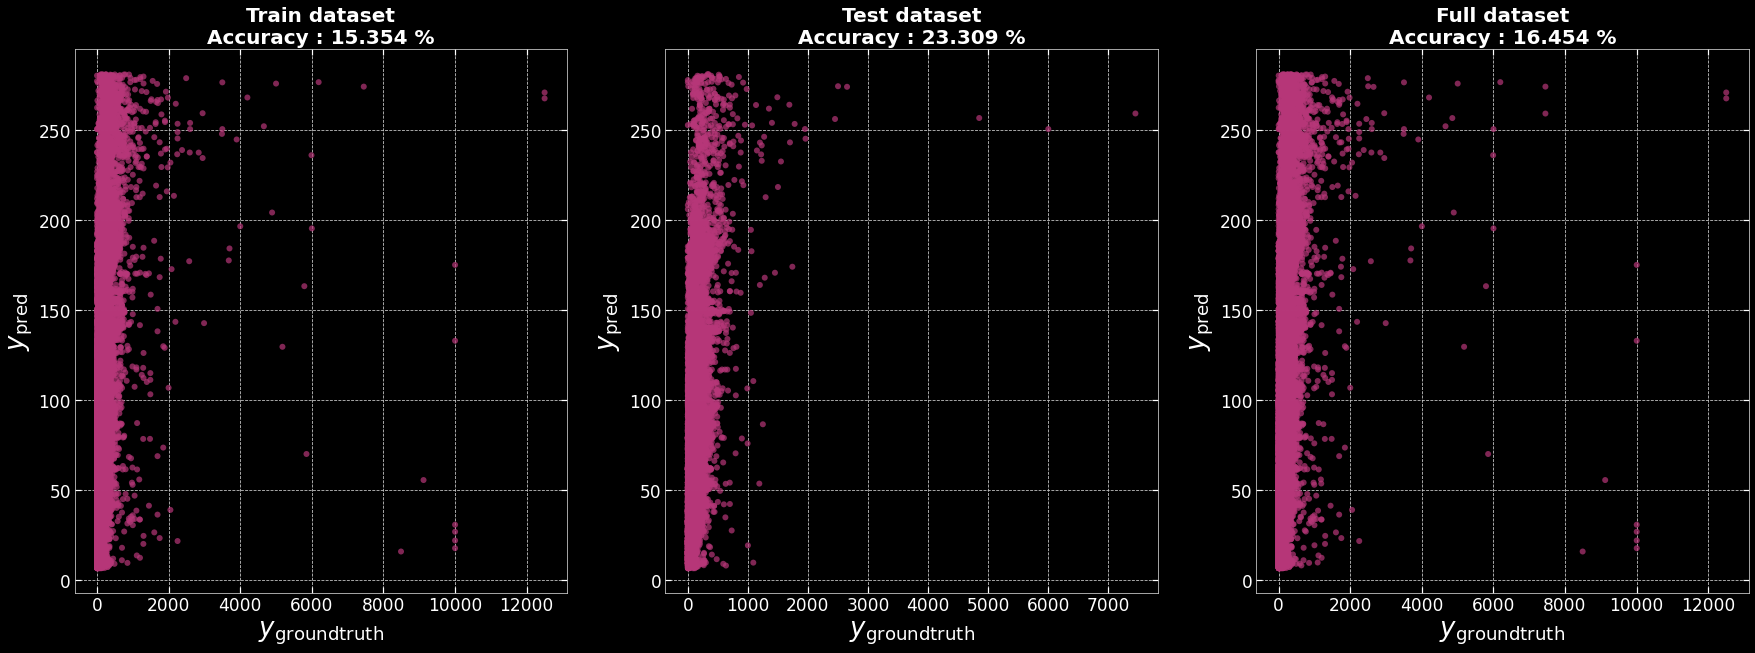

In [109]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.2, wspace=0.2)

sc = 6

# Pred and groundtruth y values
y_pred = [pred_train, pred_test, pred_full]
y_grnd = [y_train, y_test, y]
# Titles for subplots
titles = ['Train dataset', 'Test dataset', 'Full dataset']
# X values for the m=1, b=0 line
#x_line = np.linspace(0,1,80)
for i in range(ncols):
    ax = axes[i]
    
    #ax.set_xlim(0,1)
    #ax.set_ylim(0,1)
    
    ax.scatter(y_grnd[i], y_pred[i],
               color=cm.magma(0.5), marker='o', ec='none', s=sc**2, alpha=0.7)
    #ax.plot(x_line, line(x_line, m=1, b=0),
    #        color=cm.magma(0.93), lw=3, ls='--', alpha=0.7)
    ax.set_title(titles[i] + '\nAccuracy : {0:.3f} %'.format(r2_score(y_grnd[i], y_pred[i]) * 100),
                 fontsize=axistitlesize, fontweight='bold', color='white')
    ax.set_xlabel('$y_{\mathrm{groundtruth}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('$y_{\mathrm{pred}}$', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')
    
#fig.suptitle('Fig. 16. Accuracy of predictions for different test samples using an SVM regression model. In the leftmost\n' +
#             'and middle figures the model was trained only on half of the dataset then the train and test datasets were\n' +
#             'used respectively for prediction. In the rightmost figure the full dataset was used for both training\n' +
#             'and prediction.',
#             color='white', fontsize=axistitlesize+5, y=0.00)
    
plt.show()